<a href="https://www.kaggle.com/code/tejasurya/house-price-ensemble-lightgbm-xgb-lasso-ridge?scriptVersionId=132001422" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>House Price prediction</center></h1>

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Quick Navigation</center></h3>

* [House Price Prediction](#top)
* [Feature Engineering](#2)
    * [Handling Outliers](#2.1)
* [Fix Missing value](#3)
* [Exploratory Data Analysis](#4)
* [One Hot Encoding](#5)
* [Modelling](#6)
    * [Linear Regression with L1 Regularization](#6.1)
    * [Linear Regression with L2 Regularization](#6.2)
    * [XGBoost](#6.3)
    * [LightGBM](#6.4)
* [👉Ensemble- Weighted Regression Models🤔](#7)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

sns.set(style = 'darkgrid', font_scale = 1.6)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Reading Data</center></h3>

In [2]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print('train shape  {}'.format(train.shape))
print('test shape  {}'.format(test.shape))
display(train.head())
display(test.head())

train shape  (1460, 81)
test shape  (1459, 80)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [3]:
test_copy = test.copy()

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Handling Outliers</center></h3><a id=2.1></a>

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">SalePrice Distribution</h3>

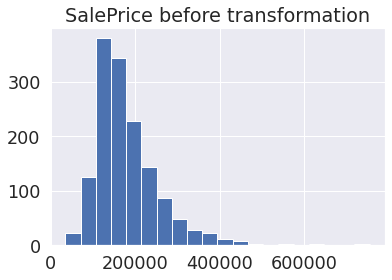

In [4]:
plt.figure()
train['SalePrice'].hist(bins=20)
plt.title('SalePrice' + ' before transformation')
plt.show()

The above plot is right skewed ,so we apply log transform to make the target variable less skew and follow Gaussian distibution , which will help to detect outliers and remove it.

In [5]:
from scipy import stats

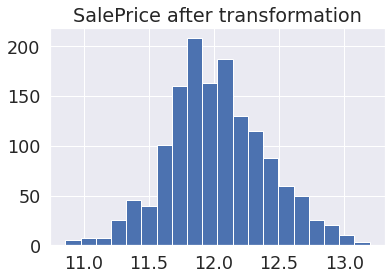

In [6]:
train['SalePrice'] = np.log(train['SalePrice'])

train['z_score_target'] = np.abs(stats.zscore(train['SalePrice']))
train = train.loc[train['z_score_target'] < 3].reset_index(drop=True)
del train['z_score_target']

plt.figure()
train['SalePrice'].hist(bins=20)
plt.title('SalePrice' + ' after transformation')
plt.show()

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Feature Engineering</center></h3><a id=2></a>

we categorize features into three groups
- Categorical
- Nominal
- Numerical

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Categorical feature</h3>

Consider Object Dtype columns as Categorical features 

In [7]:
categorical_features = ["Alley", 'MSSubClass', 'MoSold', 'MSZoning', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                        'Heating', 'CentralAir', 'Electrical', 'GarageType',
                        'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

print(len(categorical_features))

26


In [8]:
nominal_features = ["BedroomAbvGr", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                    "BsmtFullBath", "BsmtHalfBath", "BsmtQual", "ExterCond", "ExterQual",
                    "Fireplaces", "FireplaceQu", "Functional", "FullBath", "GarageCars",
                    "GarageCond", "GarageQual", "HalfBath", "HeatingQC", "KitchenAbvGr",
                    "KitchenQual", "LandSlope", "LotShape", "PavedDrive", "PoolQC",
                    "Street", "Utilities", "OverallCond", "OverallQual", "TotRmsAbvGrd"]

ordinal_features = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF',
                      '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
                      'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                      'MiscVal', 'YrSold'] 
print('Nominal features length:\t',len(nominal_features),'\nOrdinal Features length:\t',len(ordinal_features))

Nominal features length:	 30 
Ordinal Features length:	 22


In [9]:
numerical_features = nominal_features + ordinal_features
all_features = nominal_features+ ordinal_features+categorical_features

In [10]:
train = train[all_features + ['SalePrice']].copy()
test = test[all_features].copy()
display(train.head())

BedroomAbvGr BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2  BsmtFullBath  \
0             3       TA           No          GLQ          Unf             1   
1             3       TA           Gd          ALQ          Unf             0   
2             3       TA           Mn          GLQ          Unf             1   
3             3       Gd           No          ALQ          Unf             1   
4             4       TA           Av          GLQ          Unf             1   

   BsmtHalfBath BsmtQual ExterCond ExterQual  ...  Heating CentralAir  \
0             0       Gd        TA        Gd  ...     GasA          Y   
1             1       Gd        TA        TA  ...     GasA          Y   
2             0       Gd        TA        Gd  ...     GasA          Y   
3             0       TA        TA        TA  ...     GasA          Y   
4             0       Gd        TA        Gd  ...     GasA          Y   

  Electrical  GarageType  GarageFinish Fence MiscFeature  SaleType  \
0      SBrkr      Attchd           RFn   NaN         NaN        WD   
1      SBrkr      Attchd           RFn   NaN         NaN        WD   
2      SBrkr      Attchd           RFn   NaN         NaN        WD   
3      SBrkr      Detchd           Unf   NaN         NaN        WD   
4      SBrkr      Attchd           RFn   NaN         NaN        WD   

  SaleCondition  SalePrice  
0        Normal  12.247694  
1        Normal  12.109011  
2        Normal  12.317167  
3       Abnorml  11.849398  
4        Normal  12.429216  

[5 rows x 79 columns]

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BedroomAbvGr   1448 non-null   int64  
 1   BsmtCond       1412 non-null   object 
 2   BsmtExposure   1411 non-null   object 
 3   BsmtFinType1   1412 non-null   object 
 4   BsmtFinType2   1411 non-null   object 
 5   BsmtFullBath   1448 non-null   int64  
 6   BsmtHalfBath   1448 non-null   int64  
 7   BsmtQual       1412 non-null   object 
 8   ExterCond      1448 non-null   object 
 9   ExterQual      1448 non-null   object 
 10  Fireplaces     1448 non-null   int64  
 11  FireplaceQu    763 non-null    object 
 12  Functional     1448 non-null   object 
 13  FullBath       1448 non-null   int64  
 14  GarageCars     1448 non-null   int64  
 15  GarageCond     1370 non-null   object 
 16  GarageQual     1370 non-null   object 
 17  HalfBath       1448 non-null   int64  
 18  HeatingQ

In [12]:
train.describe().T

count          mean          std          min         25%  \
BedroomAbvGr   1448.0      2.867403     0.812200     0.000000     2.00000   
BsmtFullBath   1448.0      0.425414     0.519119     0.000000     0.00000   
BsmtHalfBath   1448.0      0.057320     0.238404     0.000000     0.00000   
Fireplaces     1448.0      0.610497     0.641956     0.000000     0.00000   
FullBath       1448.0      1.562155     0.544119     0.000000     1.00000   
GarageCars     1448.0      1.765884     0.740587     0.000000     1.00000   
HalfBath       1448.0      0.381906     0.502795     0.000000     0.00000   
KitchenAbvGr   1448.0      1.046961     0.221209     0.000000     1.00000   
OverallCond    1448.0      5.582182     1.111671     1.000000     5.00000   
OverallQual    1448.0      6.093923     1.351553     1.000000     5.00000   
TotRmsAbvGrd   1448.0      6.505525     1.599489     3.000000     5.00000   
LotFrontage    1189.0     69.883095    24.112300    21.000000    59.00000   
LotArea        1448.0  10488.294199  9990.704709  1300.000000  7538.75000   
YearBuilt      1448.0   1971.264503    30.132461  1872.000000  1954.00000   
YearRemodAdd   1448.0   1984.899171    20.586549  1950.000000  1967.00000   
MasVnrArea     1440.0    101.674306   175.231907     0.000000     0.00000   
BsmtFinSF1     1448.0    440.632597   450.042302     0.000000     0.00000   
BsmtFinSF2     1448.0     46.562845   161.417653     0.000000     0.00000   
BsmtUnfSF      1448.0    566.311464   440.795709     0.000000   222.50000   
TotalBsmtSF    1448.0   1053.506906   429.770560     0.000000   796.00000   
1stFlrSF       1448.0   1159.857735   379.563397   372.000000   882.00000   
2ndFlrSF       1448.0    343.837017   431.241187     0.000000     0.00000   
LowQualFinSF   1448.0      5.892956    48.821356     0.000000     0.00000   
GrLivArea      1448.0   1509.587707   507.901978   438.000000  1130.75000   
GarageArea     1448.0    472.591851   212.061761     0.000000   336.00000   
WoodDeckSF     1448.0     94.210635   125.201876     0.000000     0.00000   
OpenPorchSF    1448.0     46.219613    65.188876     0.000000     0.00000   
EnclosedPorch  1448.0     21.937845    61.169078     0.000000     0.00000   
3SsnPorch      1448.0      3.437845    29.436993     0.000000     0.00000   
ScreenPorch    1448.0     14.935773    55.631482     0.000000     0.00000   
PoolArea       1448.0      2.398481    37.638471     0.000000     0.00000   
MiscVal        1448.0     43.849448   498.160083     0.000000     0.00000   
YrSold         1448.0   2007.816298     1.327799  2006.000000  2007.00000   
MSSubClass     1448.0     57.002762    42.423084    20.000000    20.00000   
MoSold         1448.0      6.330110     2.696873     1.000000     5.00000   
SalePrice      1448.0     12.022795     0.380229    10.858999    11.77529   

                       50%           75%            max  
BedroomAbvGr      3.000000      3.000000       8.000000  
BsmtFullBath      0.000000      1.000000       3.000000  
BsmtHalfBath      0.000000      0.000000       2.000000  
Fireplaces        1.000000      1.000000       3.000000  
FullBath          2.000000      2.000000       3.000000  
GarageCars        2.000000      2.000000       4.000000  
HalfBath          0.000000      1.000000       2.000000  
KitchenAbvGr      1.000000      1.000000       3.000000  
OverallCond       5.000000      6.000000       9.000000  
OverallQual       6.000000      7.000000      10.000000  
TotRmsAbvGrd      6.000000      7.000000      14.000000  
LotFrontage      69.000000     80.000000     313.000000  
LotArea        9475.000000  11560.750000  215245.000000  
YearBuilt      1972.500000   2000.000000    2010.000000  
YearRemodAdd   1994.000000   2004.000000    2010.000000  
MasVnrArea        0.000000    164.000000    1600.000000  
BsmtFinSF1      383.500000    709.000000    5644.000000  
BsmtFinSF2        0.000000      0.000000    1474.000000  
BsmtUnfSF       475.000000    808.000000    2336.000000  
TotalB

In [13]:
print(f'Null values: {train.isnull().sum()}')

Null values: BedroomAbvGr        0
BsmtCond           36
BsmtExposure       37
BsmtFinType1       36
BsmtFinType2       37
                 ... 
Fence            1171
MiscFeature      1394
SaleType            0
SaleCondition       0
SalePrice           0
Length: 79, dtype: int64


In [14]:
nulls = pd.DataFrame(train.isna().sum().sort_values(ascending=False),columns=['null count'])
nulls

null count
PoolQC              1442
MiscFeature         1394
Alley               1358
Fence               1171
FireplaceQu          685
...                  ...
TotalBsmtSF            0
2ndFlrSF               0
LowQualFinSF           0
GrLivArea              0
SalePrice              0

[79 rows x 1 columns]

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Find the Duplicates</h3>

Check for Repeating values in the dataframe

In [15]:
# Duplicated rows
print(f"{train.duplicated().sum()} duplicates")

0 duplicates


<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Fix Missing values</center></h3><a id=3></a>

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Missing value</h3>

In [16]:
train.isna().sum()

BedroomAbvGr        0
BsmtCond           36
BsmtExposure       37
BsmtFinType1       36
BsmtFinType2       37
                 ... 
Fence            1171
MiscFeature      1394
SaleType            0
SaleCondition       0
SalePrice           0
Length: 79, dtype: int64

In [17]:
test.isna().sum()

BedroomAbvGr        0
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinType2       42
                 ... 
GarageFinish       78
Fence            1169
MiscFeature      1408
SaleType            1
SaleCondition       0
Length: 78, dtype: int64

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Imputing features</h3>

In [18]:
# calculate number of rows that contain null values
nulls = train.shape[0]-train.dropna(axis = 0).shape[0]
nulls

1448

In [19]:
nums = ['BedroomAbvGr','BsmtFullBath','BsmtHalfBath',"BsmtUnfSF","TotalBsmtSF", 
        "BsmtFinSF1","BsmtFinSF2",'EnclosedPorch',"Fireplaces",'GarageArea',
        'GarageCars','HalfBath','KitchenAbvGr','LotFrontage','MasVnrArea','MiscVal',
       'OpenPorchSF','PoolArea','ScreenPorch','TotRmsAbvGrd','WoodDeckSF']

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Data Imputation</h3>

In [20]:
for feature in train.columns:
    if feature in nums:
        train[feature].fillna(0,inplace=True)
    else:
        if feature in ["Alley","MasVnrType"]:
            train.loc[:,feature] = train.loc[:,feature].fillna("None")
        elif feature in ['BsmtQual',"MiscFeature","PoolQC",'BsmtCond',"BsmtExposure","BsmtFinType1","BsmtFinType2","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond"]:
            train.loc[:, feature] = train.loc[:, feature].fillna("No")
        elif feature in ["CentralAir","PavedDrive"]:
            train.loc[:, feature] = train.loc[:, feature].fillna("N")
        elif feature in ['Condition1','Condition2']:
            train.loc[:, feature] = train.loc[:, feature].fillna("Norm")
        elif feature in ["ExterCond","ExterQual","HeatingQC","KitchenQual"]:
            train.loc[:, feature] = train.loc[:, feature].fillna("TA")
        elif feature in ['LotShape']:
            train.loc[:, feature] = train.loc[:, feature].fillna("Reg")
        elif feature =="SaleCondition":
            train.loc[:, feature] = train.loc[:, feature].fillna("Normal")
        elif feature == "Utilities":
            train.loc[:, feature] = train.loc[:, feature].fillna("AllPub")
        

In [21]:
for feature in test.columns:
    if feature in nums:
        test[feature].fillna(0,inplace=True)
    else:
        if feature in ["Alley","MasVnrType"]:
            test.loc[:,feature] = test.loc[:,feature].fillna("None")
        elif feature in ['BsmtQual',"MiscFeature","PoolQC",'BsmtCond',"BsmtExposure","BsmtFinType1","BsmtFinType2","Fence","FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond"]:
            test.loc[:, feature] = test.loc[:, feature].fillna("No")
        elif feature in ["CentralAir","PavedDrive"]:
            test.loc[:, feature] = test.loc[:, feature].fillna("N")
        elif feature in ['Condition1','Condition2']:
            test.loc[:, feature] = test.loc[:, feature].fillna("Norm")
        elif feature in ["ExterCond","ExterQual","HeatingQC","KitchenQual"]:
            test.loc[:, feature] = test.loc[:, feature].fillna("TA")
        elif feature in ['LotShape']:
            test.loc[:, feature] = test.loc[:, feature].fillna("Reg")
        elif feature =="SaleCondition":
            test.loc[:, feature] = test.loc[:, feature].fillna("Normal")
        elif feature == "Utilities":
            test.loc[:, feature] = test.loc[:, feature].fillna("AllPub")
        elif feature == "SaleType":
            test.loc[:, feature] = test.loc[:, feature].fillna("WD")

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Exploratory Data Analysis (EDA)</center></h3><a id=4></a>


* Trying to find highly Correlated predictor videos with target value using Heatmap

In [22]:
cor =  train.corr()
train.corr().SalePrice.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.808986
GrLivArea        0.687467
GarageCars       0.674320
GarageArea       0.644909
TotalBsmtSF      0.596140
YearBuilt        0.586730
FullBath         0.582427
1stFlrSF         0.577144
YearRemodAdd     0.563476
TotRmsAbvGrd     0.514748
Fireplaces       0.481892
MasVnrArea       0.410856
BsmtFinSF1       0.355864
OpenPorchSF      0.350378
WoodDeckSF       0.333106
2ndFlrSF         0.306183
HalfBath         0.305932
LotArea          0.253800
BsmtFullBath     0.239638
BsmtUnfSF        0.218351
BedroomAbvGr     0.192054
LotFrontage      0.161439
ScreenPorch      0.115038
MoSold           0.076677
3SsnPorch        0.058304
PoolArea         0.039009
BsmtFinSF2      -0.001230
BsmtHalfBath    -0.016183
MiscVal         -0.020830
YrSold          -0.037880
LowQualFinSF    -0.039650
OverallCond     -0.049543
MSSubClass      -0.081231
EnclosedPorch   -0.143931
KitchenAbvGr    -0.154976
Name: SalePrice, dtype: float64

**Check the last column in the heatmap, to find how the predictor variables are correlated to the SalePrice target variable.**

<AxesSubplot:>

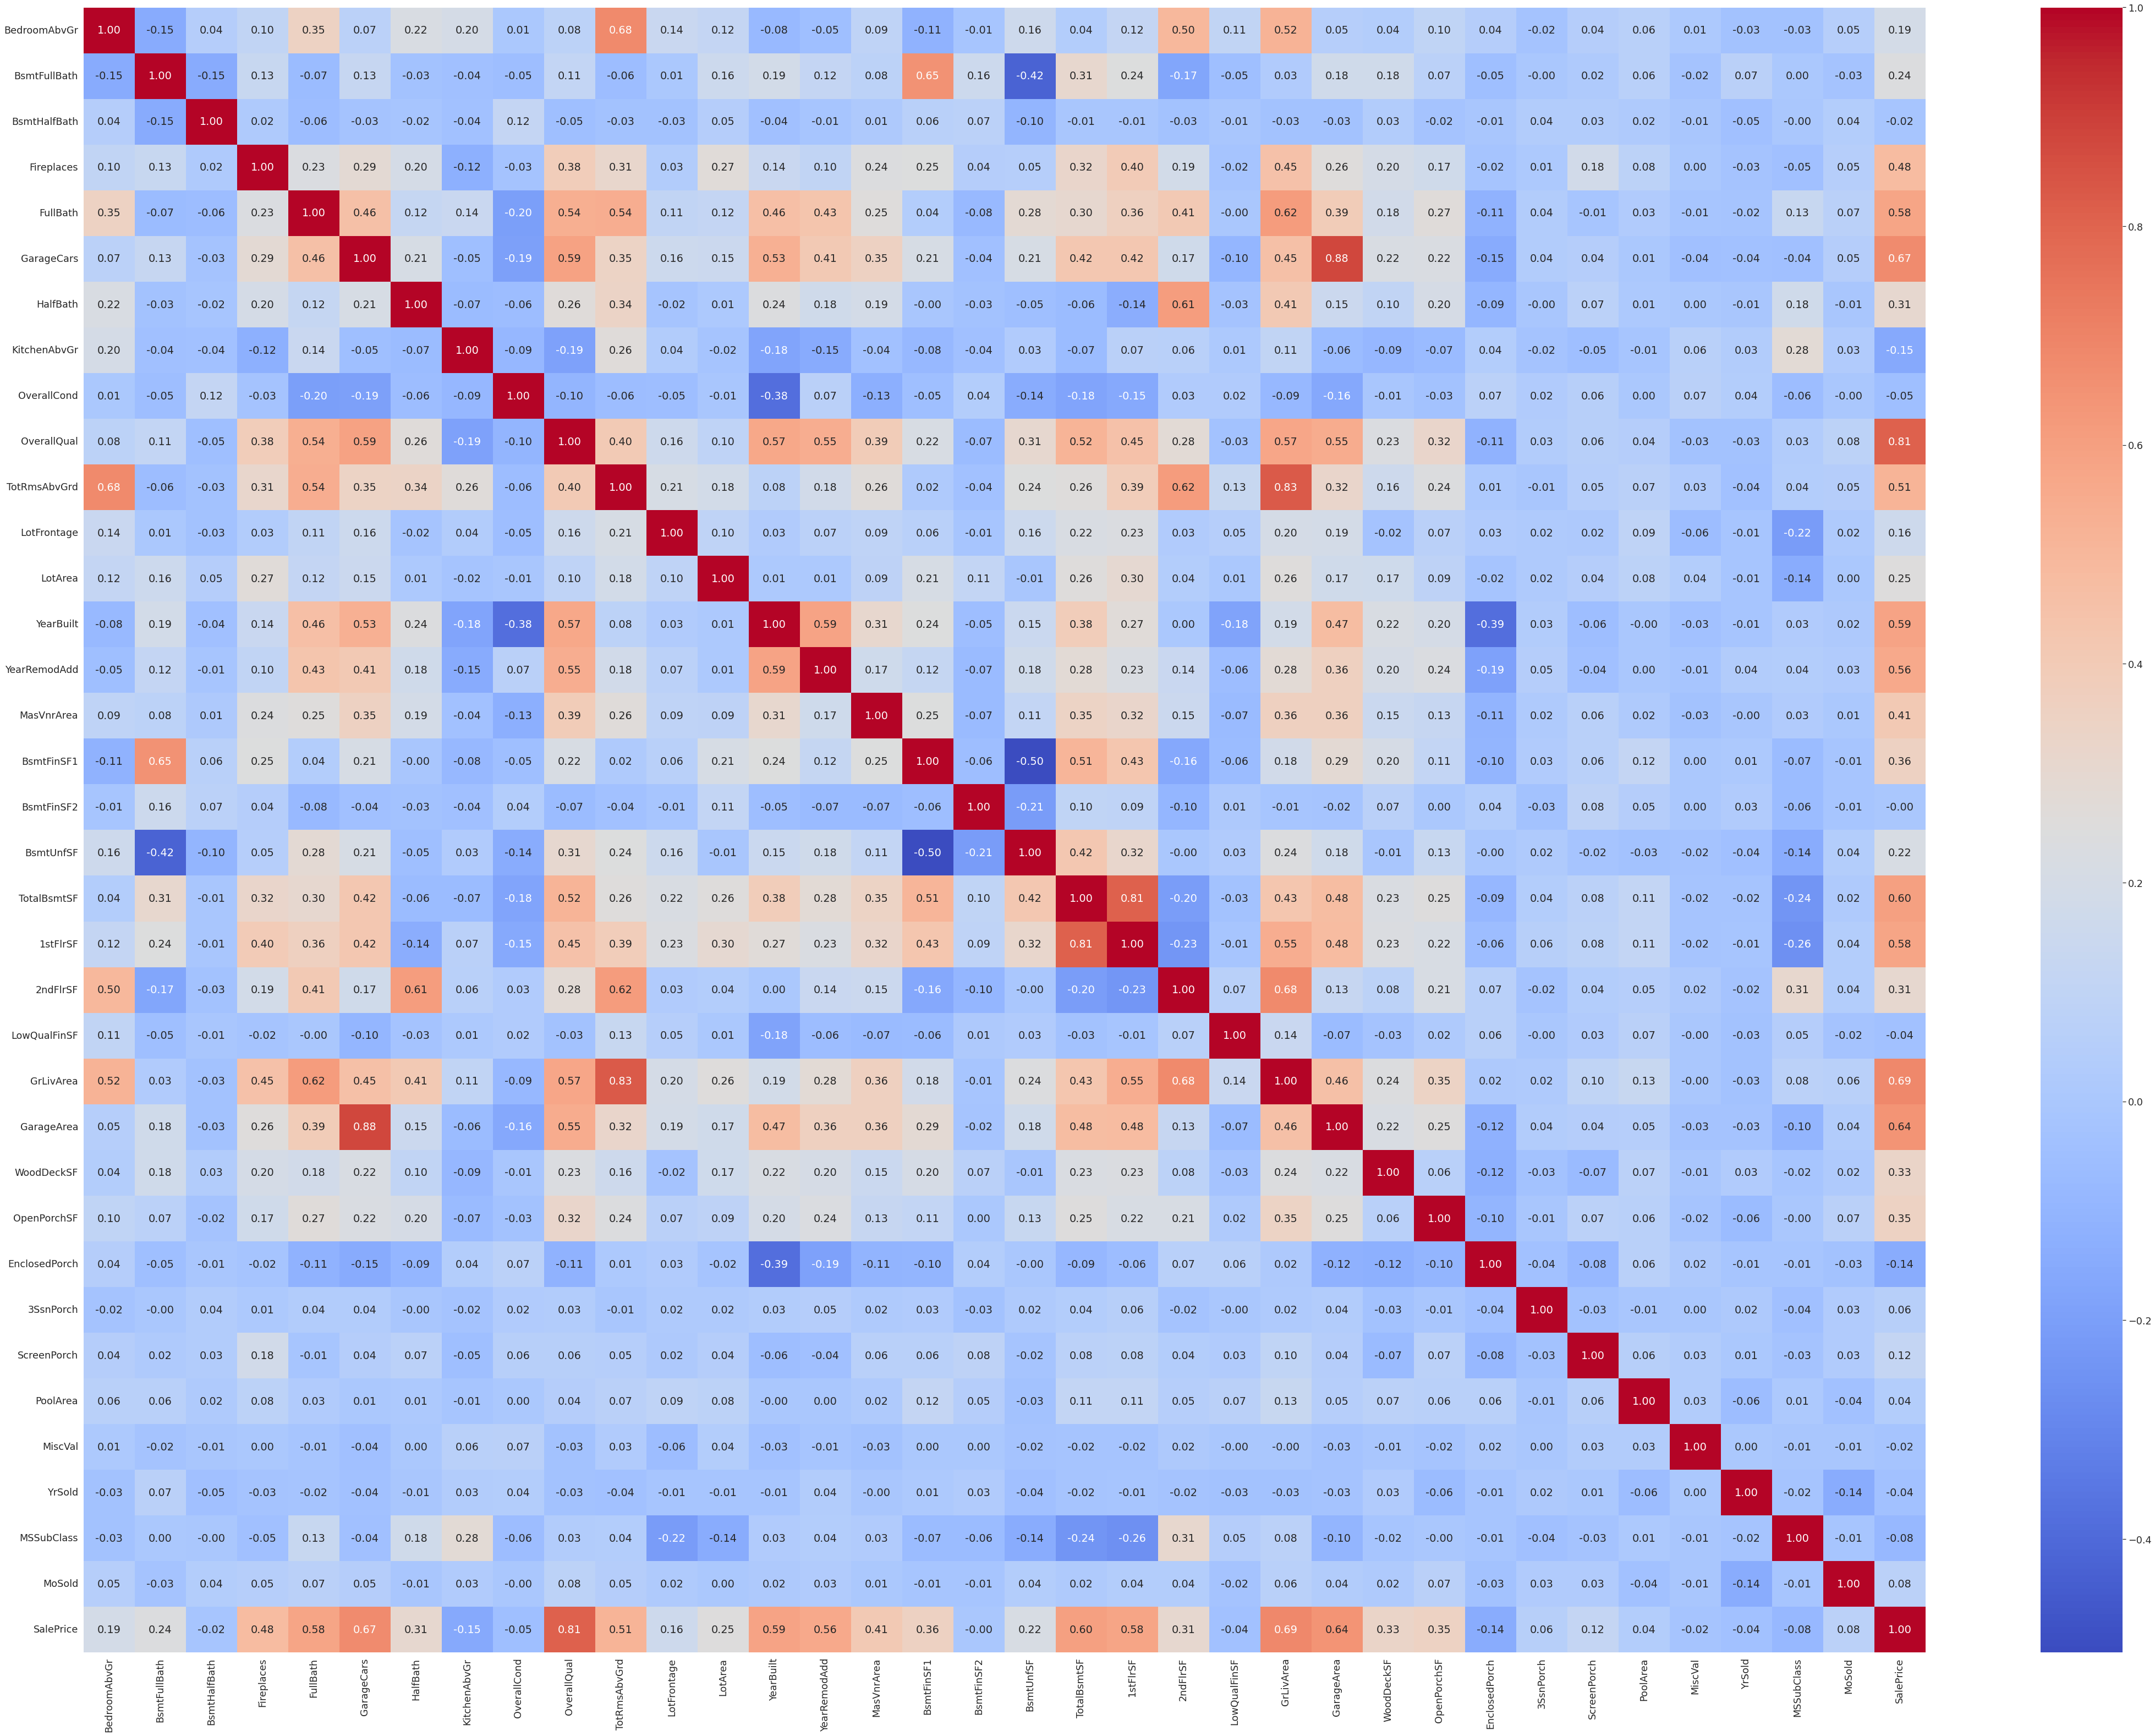

In [23]:
fig, axs = plt.subplots(1,1, figsize=(75,55))
sns.heatmap(cor,annot=True,fmt='.2f', cmap = 'coolwarm')

**Therefore OverallQuall is the most highly correlated feature with the target variable SalePrice.**

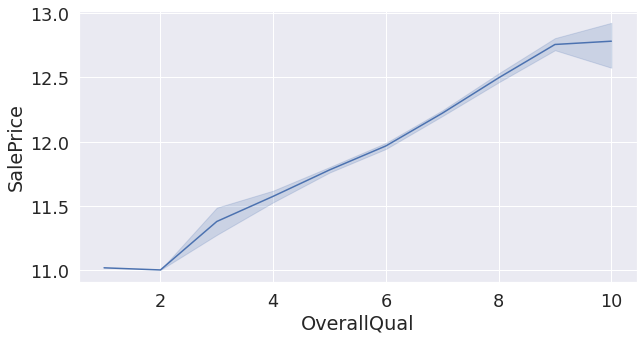

In [24]:
plt.figure(figsize = (10, 5))
sns.lineplot(data = train, x = 'OverallQual', y = 'SalePrice')
plt.show()

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Scatter plot of Ordinal features</h3>

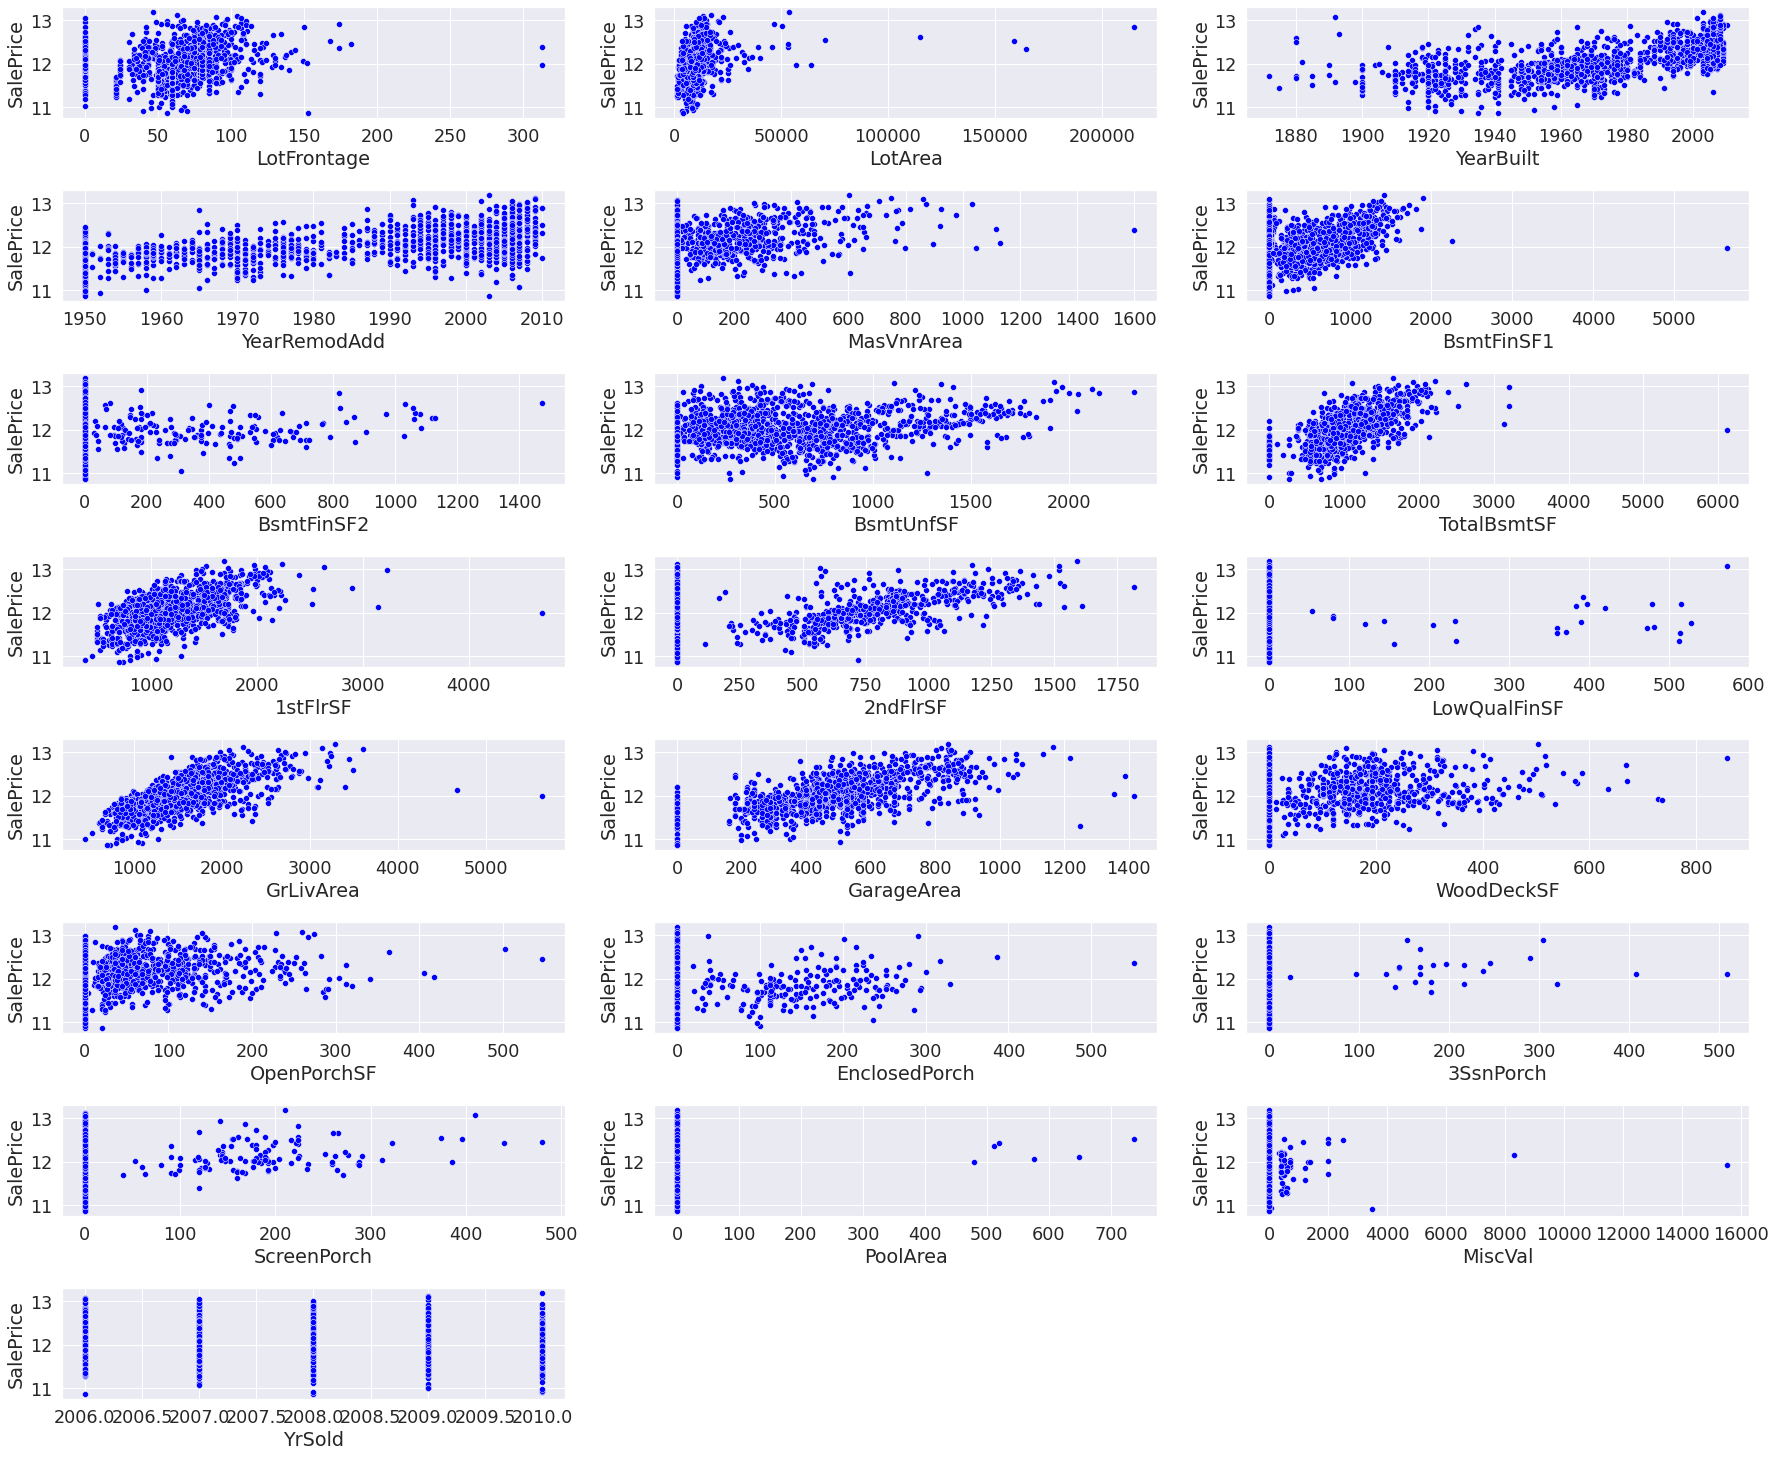

In [25]:
plt.figure(figsize = (25, 25))
for i, feature in enumerate(ordinal_features):
    plt.subplot(10, 3, i+1)
    sns.scatterplot(data = train, x = feature, y = 'SalePrice', color = 'blue')
plt.tight_layout()
plt.show()

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Remarks</h3>

* SalePrice vs. 1stFirSF and SalePrice vs. GrLivArea seem to follow a trend, which can be explained by saying that "As the prices increased, so does the area".

* SalePrice shows an unequal level of variance across most predictor(independent) variables - Heteroscedasticity. This is an issue multiple linear regression model. 

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Numerical features</h3>

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

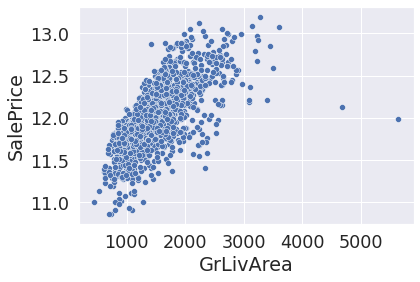

In [26]:
sns.scatterplot(data=train,x='GrLivArea', y='SalePrice')

Samples with GrLivArea greater than 4000 are obviously outliers, so delete them from our training dataset

In [27]:
train = train[train['GrLivArea'] <4000].reset_index(drop=True)

**Remove skewed parameters**

In [28]:
for feature in ordinal_features:
    if feature in ["YearBuilt", "YearRemodAdd", "YrSold"]:
        continue
    
    # if we had zero or negative value in the data, we add another column called has_zero_{feature} to the data and log non-zero values
    if (train[feature]<=0).sum()>0:
        # skip applying if we had not significant skewness
        if train.loc[train[feature]>0, feature].skew() < 0.5:
            continue
        train.loc[train[feature] > 0, feature] = np.log(train.loc[train[feature]>0, feature])

        test.loc[test[feature] > 0, feature] = np.log(test.loc[test[feature]>0, feature])

    # else we just apply log transformation
    else:
        # skip applying if we had not significant skewness
        if train[feature].skew() < 0.5:
            continue
        train[feature] = np.log(train[feature])
        test[feature] = np.log(test[feature])

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Assumptions of Regression</center></h3>

- Linearity <br>
- Homoscedasticity (absence of Heteroscedasticity).<br>
- Independence of Errors <br>
- Multivariate Normality <br>
- Low or No Multicollinearity. <br>

The best way to solve multicollinearity from the above heatmap is to use regularization methods like Ridge or Lasso or ElasticNet. It is done further below in the notebook.

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Scaling Values</h3>

In [29]:
from sklearn.preprocessing import RobustScaler
rob = RobustScaler()

train[ordinal_features] = rob.fit_transform(train[ordinal_features])
test[ordinal_features] =  rob.fit_transform(test[ordinal_features])

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor as lgb

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>One Hot Encoding</center></h3><a id=5></a>

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Encoding categorical variable</h3>

In [31]:
data_train = train.copy()
data_test = test.copy()
ohe = pd.get_dummies(data_train, columns = categorical_features)
ohe_test = pd.get_dummies(data_test, columns = categorical_features)

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Ordinal Encoding</h3>

In [32]:
from sklearn.preprocessing import OrdinalEncoder

In [33]:
oe = OrdinalEncoder()
ohe[ordinal_features] = oe.fit_transform(ohe[ordinal_features])
ohe[nominal_features] = oe.fit_transform(ohe[nominal_features])

ohe_test[ordinal_features] = oe.fit_transform(ohe_test[ordinal_features])
ohe_test[nominal_features] = oe.fit_transform(ohe_test[nominal_features])

**Concatenating Train and test dataframes**

In [34]:
total_df = pd.concat([ohe,ohe_test],ignore_index=True)
display(total_df.tail())

BedroomAbvGr  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  \
2900           3.0       4.0           3.0           6.0           6.0   
2901           3.0       4.0           3.0           5.0           6.0   
2902           4.0       4.0           3.0           0.0           6.0   
2903           3.0       4.0           0.0           2.0           6.0   
2904           3.0       4.0           0.0           3.0           6.0   

      BsmtFullBath  BsmtHalfBath  BsmtQual  ExterCond  ExterQual  ...  \
2900           0.0           0.0       4.0        4.0        3.0  ...   
2901           0.0           0.0       4.0        4.0        3.0  ...   
2902           1.0           0.0       4.0        4.0        3.0  ...   
2903           0.0           1.0       2.0        4.0        3.0  ...   
2904           0.0           0.0       2.0        4.0        3.0  ...   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
2900             0             0            1                      0   
2901             0             0            1                      1   
2902             0             0            1                      1   
2903             0             0            1                      0   
2904             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
2900                      0                     0                     0   
2901                      0                     0                     0   
2902                      0                     0                     0   
2903                      0                     0                     0   
2904                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  MSSubClass_150  
2900                     1                      0             0.0  
2901                     0                      0             0.0  
2902                     0                      0             0.0  
2903                     1                      0             0.0  
2904                     1                      0             0.0  

[5 rows x 256 columns]

In [35]:
total_df.drop(columns=['MSSubClass_150'],inplace=True)

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Split Data </center></h3>

In [36]:
# Return data to train and test
train_df = total_df[:len(ohe)]
display(train_df.head())
test_df = total_df[len(ohe):]
display(test_df.head())

BedroomAbvGr  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  \
0           3.0       4.0           3.0           2.0           6.0   
1           3.0       4.0           1.0           0.0           6.0   
2           3.0       4.0           2.0           2.0           6.0   
3           3.0       1.0           3.0           0.0           6.0   
4           4.0       4.0           0.0           2.0           6.0   

   BsmtFullBath  BsmtHalfBath  BsmtQual  ExterCond  ExterQual  ...  \
0           1.0           0.0       2.0        4.0        2.0  ...   
1           0.0           1.0       2.0        4.0        3.0  ...   
2           1.0           0.0       2.0        4.0        2.0  ...   
3           1.0           0.0       4.0        4.0        3.0  ...   
4           1.0           0.0       2.0        4.0        2.0  ...   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 255 columns]

BedroomAbvGr  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  \
1446           2.0       4.0           3.0           5.0           3.0   
1447           3.0       4.0           3.0           0.0           6.0   
1448           3.0       4.0           3.0           2.0           6.0   
1449           3.0       4.0           3.0           2.0           6.0   
1450           2.0       4.0           3.0           0.0           6.0   

      BsmtFullBath  BsmtHalfBath  BsmtQual  ExterCond  ExterQual  ...  \
1446           0.0           0.0       4.0        4.0        3.0  ...   
1447           0.0           0.0       4.0        4.0        3.0  ...   
1448           0.0           0.0       2.0        4.0        3.0  ...   
1449           0.0           0.0       4.0        4.0        3.0  ...   
1450           0.0           0.0       2.0        4.0        2.0  ...   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
1446               0             0             0            1   
1447               0             0             0            1   
1448               0             0             0            1   
1449               0             0             0            1   
1450               0             0             0            1   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
1446                      0                      0                     0   
1447                      0                      0                     0   
1448                      0                      0                     0   
1449                      0                      0                     0   
1450                      0                      0                     0   

      SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
1446                     0                     1                      0  
1447                     0                     1                      0  
1448                     0                     1                      0  
1449                     0                     1                      0  
1450                     0                     1                      0  

[5 rows x 255 columns]

In [37]:
train_df['SalePrice'] = train['SalePrice']
train_df.shape,test_df.shape

((1446, 255), (1459, 255))

In [38]:
train_df.SalePrice.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

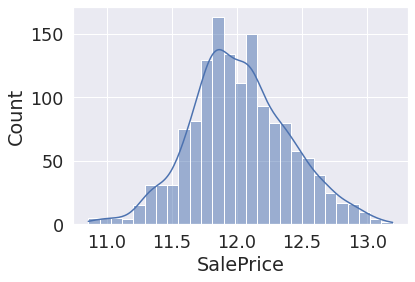

In [39]:
sns.histplot(train_df['SalePrice'], kde =True)

In [40]:
x = train_df.drop(columns=['SalePrice'],axis=1)
y = train_df['SalePrice']

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Modelling </center></h3><a id=6></a>

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1,random_state=42)

In [43]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1170, 254), (1170,), (145, 254), (145,))

In [44]:
test_f = test_df.drop(columns=['SalePrice'])
test_f = test_f.fillna(0)

In [45]:
from sklearn.linear_model import Lasso,LinearRegression,Ridge,ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Performance metrics</h3>

In [46]:
def regression_metrics(y_test,y_pred):
    print('explained_variance: ', round(explained_variance_score(y_test,y_pred),4))  
    print('r2: ', round(r2_score(y_test,y_pred),4))
    print("MAE:\t",round(mean_absolute_error(y_test,y_pred),4))
    print("MSE:\t",round(mean_squared_error(y_test,y_pred),4))
    print("RMSE:\t",round(np.sqrt(mean_squared_error(y_test,y_pred)),4))


<h3 class="list-group-item list-group-item-action active" style='color:#0096FF ; background:white' role="tab" aria-controls="home">Cross Validation - GridSearchCV</h3>

In [47]:
def model_evaluate(model, param_grid, x_train, y_train, x_test,y_test, model_name, k_folds=5, scoring='neg_mean_squared_error', fit_parameters={}):

    model_cv = GridSearchCV(model, param_grid, cv=k_folds, verbose=False, scoring= scoring, refit=True)
    model_cv.fit(x_train, y_train, **fit_parameters)
    y_train_pred = model_cv.predict(x_train)
    y_test_pred = model_cv.predict(x_test)

    print('Mean Squared Error = ', np.abs(model_cv.score(x_train, y_train)))
    print("Training metrics:")
    regression_metrics(y_train ,y_train_pred)
    print("\nTesting metrics:")
    regression_metrics(y_test ,y_test_pred)
    
    return model_cv

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Linear Regression with L1 regularization - Lasso</center></h3><a id=6.1></a>

In [48]:
lasso = Lasso(alpha =0.0005, random_state=20)
#param_grid = [{'alpha':[0.001, 0.005, 0.01, 0.05, 0.03, 0.1, 0.5, 1]}]
param_grid = [{'alpha':[0.0005]}]
lasso_model = model_evaluate(lasso, param_grid, x_train, y_train, x_test, y_test, 'Lasso',k_folds=5)
lasso_pred = np.exp(lasso_model.predict(test_f))

Mean Squared Error =  0.009563961993142255
Training metrics:
explained_variance:  0.9326
r2:  0.9326
MAE:	 0.0698
MSE:	 0.0096
RMSE:	 0.0978

Testing metrics:
explained_variance:  0.9299
r2:  0.9299
MAE:	 0.075
MSE:	 0.0108
RMSE:	 0.104


In [49]:
submission_lasso = pd.DataFrame({'Id': test_copy.Id, 'SalePrice': lasso_pred})
submission_lasso.to_csv(path_or_buf = 'submission_lasso.csv', index = False)
pd.read_csv('submission_lasso.csv')

Id      SalePrice
0     1461  122286.556770
1     1462  151490.062479
2     1463  187764.566042
3     1464  199657.008649
4     1465  193708.947115
...    ...            ...
1454  2915   88700.635963
1455  2916   81237.013461
1456  2917  180951.956916
1457  2918  121339.944214
1458  2919  238503.863685

[1459 rows x 2 columns]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Linear Regression with L2 regularization - Ridge</center></h3><a id=6.2></a>

In [50]:
ridge = Ridge(random_state=20, max_iter=10000)
learning_rate = [0.0005,0.001, 0.005, 0.01, 0.05, 0.03, 0.1, 0.5,0.6, 1]
param_grid = [{'alpha': learning_rate}]

ridge_model = model_evaluate(ridge, param_grid, x_train, y_train, x_test, y_test, 'Ridge',k_folds=5)

Mean Squared Error =  0.008373886859907148
Training metrics:
explained_variance:  0.941
r2:  0.941
MAE:	 0.0654
MSE:	 0.0084
RMSE:	 0.0915

Testing metrics:
explained_variance:  0.923
r2:  0.9227
MAE:	 0.0798
MSE:	 0.0119
RMSE:	 0.1092


In [51]:
ridge_pred = np.exp(ridge_model.predict(test_f))
submission_ridge = pd.DataFrame({'Id': test_copy.Id, 'SalePrice': ridge_pred})
submission_ridge.to_csv(path_or_buf = 'submission_ridge.csv', index = False)
pd.read_csv('submission_ridge.csv')

Id      SalePrice
0     1461  125585.131877
1     1462  145589.853897
2     1463  186801.846928
3     1464  195054.383000
4     1465  197317.924486
...    ...            ...
1454  2915   85245.848487
1455  2916   74458.033084
1456  2917  174163.692408
1457  2918  118685.372629
1458  2919  226375.637613

[1459 rows x 2 columns]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>XGBoost</center></h3><a id=6.3></a>

In [52]:
from xgboost import XGBRegressor as xgr
import xgboost as xgb

In [53]:
xgr_model = xgr()
param_grid = {'learning_rate':[0.01],'max_depth':[6],'n_estimators':[1000],'min_child_weight':[0.5],'colsample_bytree':[0.5],'subsample':[0.5], 'eta':[0.1],'seed':[42]} 

model_xgr = model_evaluate(xgr_model, param_grid, x_train, y_train, x_test, y_test, 'XGBM',fit_parameters={'eval_set':[(x_val, y_val)], 'eval_metric':'rmse'})

[0]	validation_0-rmse:11.43721
[1]	validation_0-rmse:11.32328
[2]	validation_0-rmse:11.21052
[3]	validation_0-rmse:11.09909
[4]	validation_0-rmse:10.98869
[5]	validation_0-rmse:10.87935
[6]	validation_0-rmse:10.77099
[7]	validation_0-rmse:10.66366
[8]	validation_0-rmse:10.55743
[9]	validation_0-rmse:10.45249
[10]	validation_0-rmse:10.34843
[11]	validation_0-rmse:10.24512
[12]	validation_0-rmse:10.14285
[13]	validation_0-rmse:10.04196
[14]	validation_0-rmse:9.94211
[15]	validation_0-rmse:9.84314
[16]	validation_0-rmse:9.74499
[17]	validation_0-rmse:9.64787
[18]	validation_0-rmse:9.55184
[19]	validation_0-rmse:9.45687
[20]	validation_0-rmse:9.36253
[21]	validation_0-rmse:9.26928
[22]	validation_0-rmse:9.17674
[23]	validation_0-rmse:9.08535
[24]	validation_0-rmse:8.99503
[25]	validation_0-rmse:8.90571
[26]	validation_0-rmse:8.81707
[27]	validation_0-rmse:8.72921
[28]	validation_0-rmse:8.64243
[29]	validation_0-rmse:8.55643
[30]	validation_0-rmse:8.47123
[31]	validation_0-rmse:8.38725
[32]

In [54]:

xgr_pred= np.exp(model_xgr.predict(test_f))


XGBoost Output

In [55]:
submission_xgb = pd.DataFrame({'Id': test_copy.Id, 'SalePrice': xgr_pred})
submission_xgb.to_csv(path_or_buf = 'submission_xgr.csv', index = False)
pd.read_csv('submission_xgr.csv')

Id  SalePrice
0     1461  129320.25
1     1462  160367.58
2     1463  183732.10
3     1464  192380.69
4     1465  194500.16
...    ...        ...
1454  2915   90646.92
1455  2916   92597.29
1456  2917  167862.27
1457  2918  123899.88
1458  2919  230590.39

[1459 rows x 2 columns]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>LightGBM</center></h3><a id=6.4></a>

In [56]:
lgb_model = lgb()

In [57]:
param_grid = {'learning_rate':[0.01], 'num_iterations': [10000], 'n_estimators': [25], 'num_leaves': [40],'colsample_bytree':[0.4], 'subsample': [0.4], 'max_depth': [6]} 

model_lgb = model_evaluate(lgb_model, param_grid, x_train, y_train, x_test, y_test, 'LGBM', fit_parameters={'eval_set':[(x_val, y_val)], 'eval_metric':'rmse'})

[1]	valid_0's rmse: 0.39075	valid_0's l2: 0.152686
[2]	valid_0's rmse: 0.38767	valid_0's l2: 0.150288
[3]	valid_0's rmse: 0.384624	valid_0's l2: 0.147936
[4]	valid_0's rmse: 0.381611	valid_0's l2: 0.145627
[5]	valid_0's rmse: 0.378766	valid_0's l2: 0.143463
[6]	valid_0's rmse: 0.37597	valid_0's l2: 0.141354
[7]	valid_0's rmse: 0.373088	valid_0's l2: 0.139195
[8]	valid_0's rmse: 0.370385	valid_0's l2: 0.137185
[9]	valid_0's rmse: 0.367404	valid_0's l2: 0.134986
[10]	valid_0's rmse: 0.364791	valid_0's l2: 0.133073
[11]	valid_0's rmse: 0.361844	valid_0's l2: 0.130931
[12]	valid_0's rmse: 0.359035	valid_0's l2: 0.128906
[13]	valid_0's rmse: 0.356234	valid_0's l2: 0.126903
[14]	valid_0's rmse: 0.353645	valid_0's l2: 0.125065
[15]	valid_0's rmse: 0.351367	valid_0's l2: 0.123459
[16]	valid_0's rmse: 0.348746	valid_0's l2: 0.121624
[17]	valid_0's rmse: 0.346074	valid_0's l2: 0.119767
[18]	valid_0's rmse: 0.343529	valid_0's l2: 0.118012
[19]	valid_0's rmse: 0.34083	valid_0's l2: 0.116165
[20]	v

In [58]:
lgb_pred= np.exp(model_lgb.predict(test_f))

LightGBM Output

In [59]:
prediction_lgb = model_lgb.predict(test_f)
submission_lgb = pd.DataFrame({'Id': test_copy.Id, 'SalePrice': np.exp(prediction_lgb)})
submission_lgb.to_csv(path_or_buf = 'submission_lgb.csv', index = False)
pd.read_csv('submission_lgb.csv')

Id      SalePrice
0     1461  121612.511165
1     1462  147618.156453
2     1463  188301.432413
3     1464  194110.045217
4     1465  182325.299478
...    ...            ...
1454  2915   86435.046915
1455  2916   94515.244292
1456  2917  163955.695562
1457  2918  124077.434531
1458  2919  230801.037444

[1459 rows x 2 columns]

<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:#0096FF' role="tab" aria-controls="home"><br><center>Ensembling - Weighted Regression Models🤔</center></h3><a id=7></a>

**Calculating weighted output of Lasso , Ridge, XGBoost and LightGBM**

* The best model with good hyperparameter tuning could have been better. In this case Lasso(L1 regulariation with GridSearchCV) was the best model for me in terms of the score. Initially Lasso alone gave me the best score.

* Since I also performed model Analysis with other different models and had their outputs; as an experiment, I played around by adding different weights to those regression output. Thought process was to add small value(bias kind) to lasso's output and try to reduce the error. It did improve the score.

* Manually tried various combinations of weights to these outputs. 

In [60]:
w1,w2,w3,w4 = 0.7,0.032,0.032,0.2

In [61]:
ensemble = w1*lasso_pred + w2*ridge_pred + w3*xgr_pred + w4*lgb_pred

**Submission**

In [62]:
submission = pd.DataFrame()
submission['Id'] = test_copy.Id
submission['SalePrice'] = ensemble
submission.to_csv('submission.csv',index=False)
pd.read_csv('submission.csv')


Id      SalePrice
0     1461  118080.064239
1     1462  145357.313046
2     1463  180952.569060
3     1464  190979.837482
4     1465  184599.501831
...    ...            ...
1454  2915   85006.023369
1455  2916   81114.728621
1456  2917  170402.339884
1457  2918  117516.176167
1458  2919  227735.825538

[1459 rows x 2 columns]

Please do upvote , if you liked it. Thanks in advance.  -`@tejasurya`